#  Develop population-level functional forms for ellipticity

This notebook shows the (largely experimental) process I used to arrive at the functional forms I used to approximate $P({\rm e}(t)\vert M_0),$ the evolution of ellipticity for a population of halos with present-day peak mass, $M_0.$ 

In [1]:
%matplotlib inline

In [2]:
from diffprof.load_diffprof_fits import load_bpl_fits, load_mdpl2_fits

drn = "/Users/aphearin/work/DATA/diffprof_data"

bpl_fits = load_bpl_fits(drn)

mdpl_fits = load_mdpl2_fits(drn)
print(sorted(mdpl_fits.keys()))

['conc_early', 'conc_k', 'conc_late', 'conc_lgtc', 'e_early', 'e_k', 'e_late', 'e_lgtc', 'halo_id', 'logmp', 'mah_early', 'mah_k', 'mah_late', 'mah_lgtc']


### Map synthetic histories onto the halos based on the fits

In [3]:
from jax import vmap
from diffprof.ellipticity_evolution import ellipticity_vs_time

e_vs_t_vmap = jjit(vmap(ellipticity_vs_time, in_axes=(None, 0, 0, 0, 0)))

tarr = np.linspace(1, 13.8, 100)

_args = 10**mdpl_fits['e_lgtc'], mdpl_fits['e_k'], mdpl_fits['e_early'], mdpl_fits['e_late']
mdpl_fits['e_history'] = e_vs_t_vmap(tarr, *_args)

_args = 10**bpl_fits['e_lgtc'], bpl_fits['e_k'], bpl_fits['e_early'], bpl_fits['e_late']
bpl_fits['e_history'] = e_vs_t_vmap(tarr, *_args)


# Study $\log_{10}M_{\rm halo}=13.5$

For purposes of developing the functional forms, I'll focus on halos of a particular mass. For each of the 4 parameters, I'll visually inspect the histogram, and try to devise the simplest possible model for what I see. Remember that the end goal is actually to have a good model for the first and second moments of $P({\rm e}(t)\vert M_0),$ so we don't need the actual PDFs of the parameters to be perfect: we only need to capture the bulk trend good enough to get the mean and variance correct of the ellipticity of the halo population across time.

### Inspect the mean and variance of ellipticity

First let's just take a look at the underlying trend of ellipticity evolution that we want to capture: the mean and variance of ${\rm e}(t)$:

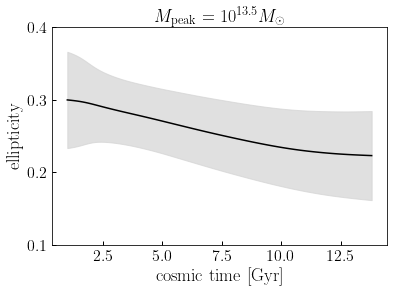

In [4]:
mmsk = np.abs(mdpl_fits['logmp'] - 13.5) < 0.1
sample = mdpl_fits[mmsk]

e_h_med = np.mean(sample['e_history'], axis=0)
e_h_std = np.std(sample['e_history'], axis=0)

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0.1, 0.4)
__=ax.fill_between(tarr, e_h_med-e_h_std, e_h_med+e_h_std, alpha=0.7, color='lightgray')
__=ax.plot(tarr, e_h_med, color='k')

xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'${\rm ellipticity}$')
title = ax.set_title(r'$M_{\rm peak}=10^{13.5}M_{\odot}$')


### study lgtc

Let's start out by building an approximating model for `e_lgtc`. First things first, let's look at the histogram.

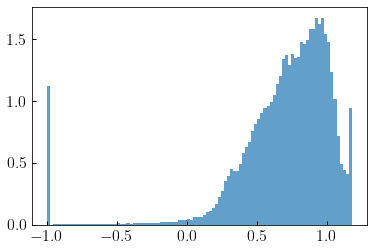

In [5]:
fig, ax = plt.subplots(1, 1)
__=ax.hist(sample['e_lgtc'], bins=100, density=True, alpha=0.7)

This distribution looks at least roughly Gaussian, so we'll start by simply measuring the first and second moment and seeing how the Gaussian approximation looks:

0.7004157307217637 0.37330773562015795


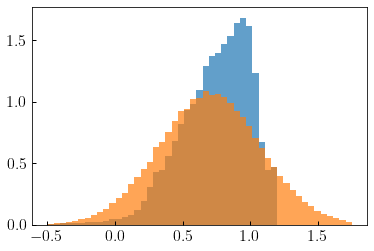

In [6]:
fig, ax = plt.subplots(1, 1)
b = np.linspace(-0.5, 1.75, 50)

__=ax.hist(sample['e_lgtc'], bins=b, density=True, alpha=0.7)

mu_lgtc, std_lgtc = np.mean(sample['e_lgtc']), np.std(sample['e_lgtc'])
print(mu_lgtc, std_lgtc)
e_lgtc_model = np.random.normal(loc=mu_lgtc, scale=std_lgtc, size=len(sample))
__=ax.hist(e_lgtc_model, bins=b, density=True, alpha=0.7)


Ok so the Gaussian approximation looks decent, but we appear to have a biased mean and variance. The reason is probably those outlier points. So let's try again by excluding those points when computing the mean and variance. In the end, we hopefully don't need to reproduce those outliers anyway, so let's see how we can do by ignoring them:

0.7364216167428177 0.2503136621132109


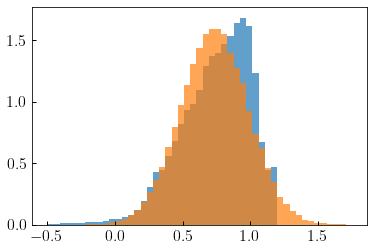

In [7]:
_msk = sample['e_lgtc'] > -0.5
_msk &= sample['e_lgtc'] < sample['e_lgtc'].max()-0.02
mu_lgtc, std_lgtc = np.mean(sample['e_lgtc'][_msk]), np.std(sample['e_lgtc'][_msk])
print(mu_lgtc, std_lgtc)
fig, ax = plt.subplots(1, 1)
b = np.linspace(-0.5, 1.75, 50)

__=ax.hist(sample['e_lgtc'], bins=b, density=True, alpha=0.7)

e_lgtc_model = np.random.normal(loc=mu_lgtc, scale=std_lgtc, size=len(sample))
__=ax.hist(e_lgtc_model, bins=b, density=True, alpha=0.7)

Now that we have a rough approximation to this component of the PDF, let's check to see whether our by-eye approximation has us in the ballpark of the right model. The way we'll do this check is to simply overwrite the true values of `e_lgtc` with our synthetic values, generate a new collection of histories, and compare the results.

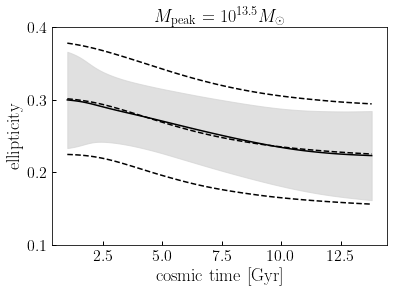

In [8]:
_args = 10**sample['e_lgtc'], sample['e_k'], sample['e_early'], sample['e_late']
e_history_sample = e_vs_t_vmap(tarr, *_args)

sample['e_lgtc_model'] = e_lgtc_model
_args = 10**sample['e_lgtc_model'], sample['e_k'], sample['e_early'], sample['e_late']
e_history_model = e_vs_t_vmap(tarr, *_args)

e_h_med_true = np.mean(e_history_sample, axis=0)
e_h_std_true = np.std(e_history_sample, axis=0)

e_h_med_model = np.mean(e_history_model, axis=0)
e_h_std_model = np.std(e_history_model, axis=0)

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0.1, 0.4)
__=ax.fill_between(tarr, e_h_med_true-e_h_std_true, e_h_med_true+e_h_std_true, alpha=0.7, color='lightgray')
__=ax.plot(tarr, e_h_med_true, color='k')


__=ax.plot(tarr, e_h_med_model, '--', color='k')
__=ax.plot(tarr, e_h_med_model-e_h_std_model, '--', color='k')
__=ax.plot(tarr, e_h_med_model+e_h_std_model, '--', color='k')

xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'${\rm ellipticity}$')
title = ax.set_title(r'$M_{\rm peak}=10^{13.5}M_{\odot}$')


Not bad for a hand-tuned result! We could go back and try and decrease the variance a bit and see if that tightens up the fit, but in the end we're going to hand things over to an automated fitting algorithm anyway, so what we're looking for here is just that the approximation is giving broadly reasonable results, and that appears to be the case. So for now, let's move on to the next parameter, and just make a mental note that we may need to come back and improve some aspect of how `e_lgtc`.

### study k

2.685732781787641 1.4888181887119825


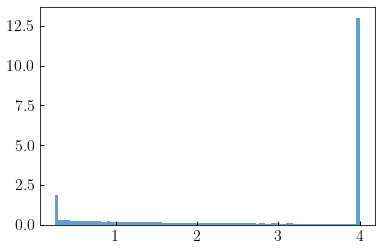

In [9]:
fig, ax = plt.subplots(1, 1)
b = np.linspace(-0.5, 1.75, 50)

__=ax.hist(sample['e_k'], bins=100, density=True, alpha=0.7)

mu, std = np.mean(sample['e_k']), np.std(sample['e_k'])
print(mu, std)

Ok, wow, that looks like a bit of a weird distribution to model. There are two heavily populated outlier populations, and a sort of uniformly distribution middle region. One thing we should do is check the relative abundance of these three subpopulations:

In [10]:
himsk = sample['e_k']>3.9
lomsk = sample['e_k']<0.3
print(np.mean(lomsk), np.mean(~lomsk&~himsk), np.mean(himsk))

0.0717342515020143 0.43684570026625036 0.49142004823173535


Ok, got it: half the population is comprised of the high-k outliers, 7% are low-k outliers, and the rest are somewhere in the middle. Let's see how _just_ the middle population is distributed:

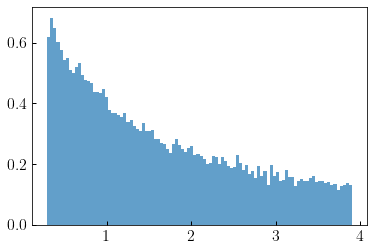

In [11]:
fig, ax = plt.subplots(1, 1)
b = np.linspace(-0.5, 1.75, 50)

__=ax.hist(sample['e_k'][~himsk&~lomsk], bins=100, density=True, alpha=0.7)


Hmmm, well that's sort of power-law-ish, so one thing we could consider is to model this distribution as a 3-component distribution where we have a model that specifies how halos are apportioned into the 3 components, and for those halos that are apportioned into the middle region, we capture the k-dependence with a power law.

However, that sounds pretty complicated. And I have a hunch that this k parameter is not so important. So before going down that road, let's first just test the success of a _really_ simple model for the k PDF: a simple uniform distribution between the min and max values.

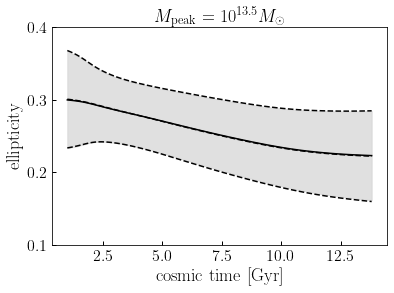

In [12]:
e_k_model = np.random.uniform(sample['e_k'].min(), sample['e_k'].max(), len(sample))
idx_sorted_e_k = np.argsort(sample['e_k'])
sample['e_k_model'] = 0.
sample['e_k_model'][idx_sorted_e_k] = np.sort(e_k_model)

_args = 10**sample['e_lgtc'], sample['e_k'], sample['e_early'], sample['e_late']
e_history_sample = e_vs_t_vmap(tarr, *_args)

_args = 10**sample['e_lgtc'], sample['e_k_model'], sample['e_early'], sample['e_late']
e_history_model = e_vs_t_vmap(tarr, *_args)

e_h_med_true = np.mean(e_history_sample, axis=0)
e_h_std_true = np.std(e_history_sample, axis=0)

e_h_med_model = np.mean(e_history_model, axis=0)
e_h_std_model = np.std(e_history_model, axis=0)

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0.1, 0.4)
__=ax.fill_between(tarr, e_h_med_true-e_h_std_true, e_h_med_true+e_h_std_true, alpha=0.7, color='lightgray')
__=ax.plot(tarr, e_h_med_true, color='k')


__=ax.plot(tarr, e_h_med_model, '--', color='k')
__=ax.plot(tarr, e_h_med_model-e_h_std_model, '--', color='k')
__=ax.plot(tarr, e_h_med_model+e_h_std_model, '--', color='k')

xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'${\rm ellipticity}$')
title = ax.set_title(r'$M_{\rm peak}=10^{13.5}M_{\odot}$')


Yup, my hunch looks like it was right. There is no need to consider a complicated model for `e_k`, because this parameter is not very important. To further demonstrate this, let's see how things look if we simply pretended as if every halo had exactly the same k value:

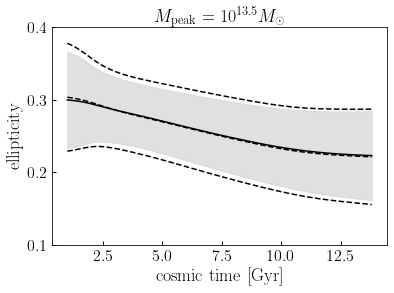

In [13]:
e_k_model = np.random.uniform(sample['e_k'].min(), sample['e_k'].max(), len(sample))
idx_sorted_e_k = np.argsort(sample['e_k'])
sample['e_k_model'] = sample['e_k'].mean()

_args = 10**sample['e_lgtc'], sample['e_k'], sample['e_early'], sample['e_late']
e_history_sample = e_vs_t_vmap(tarr, *_args)

_args = 10**sample['e_lgtc'], sample['e_k_model'], sample['e_early'], sample['e_late']
e_history_model = e_vs_t_vmap(tarr, *_args)

e_h_med_true = np.mean(e_history_sample, axis=0)
e_h_std_true = np.std(e_history_sample, axis=0)

e_h_med_model = np.mean(e_history_model, axis=0)
e_h_std_model = np.std(e_history_model, axis=0)

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0.1, 0.4)
__=ax.fill_between(tarr, e_h_med_true-e_h_std_true, e_h_med_true+e_h_std_true, alpha=0.7, color='lightgray')
__=ax.plot(tarr, e_h_med_true, color='k')


__=ax.plot(tarr, e_h_med_model, '--', color='k')
__=ax.plot(tarr, e_h_med_model-e_h_std_model, '--', color='k')
__=ax.plot(tarr, e_h_med_model+e_h_std_model, '--', color='k')

xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'${\rm ellipticity}$')
title = ax.set_title(r'$M_{\rm peak}=10^{13.5}M_{\odot}$')


Ok, even _that_ is not so bad. So the lesson here is that we shouldn't spend a lot of our time trying to model what's going on with k. And the bigger lesson is more general: we should only try to capture the trends that we need in order to achieve our goal of approximating $P({\rm e}(t)\vert M_0).$

### Study $\beta_{\rm early}$ & $\beta_{\rm late}$

From the plots that Dash already showed us on Slack, we know that $\beta_{\rm early}$ & $\beta_{\rm late}$ are highly correlated parameters with a bimodal distribution. So keeping in mind the lesson we learned from modeling `e_k`, we'll try and keep it as simple as possible, but we sort of already know we may need to consider these parameters in tandem. First things first, a reminder of what the distribution looks like: 

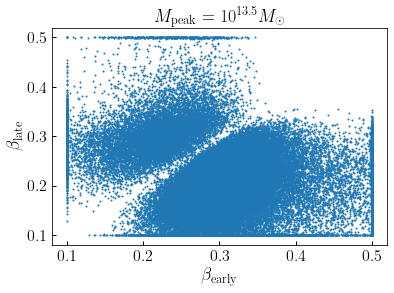

In [14]:
fig, ax = plt.subplots(1, 1)
__=ax.scatter(sample['e_early'], sample['e_late'], s=1)
xlabel = ax.set_xlabel(r'$\beta_{\rm early}$')
ylabel = ax.set_ylabel(r'$\beta_{\rm late}$')
title = ax.set_title(r'$M_{\rm peak}=10^{13.5}M_{\odot}$')


Ok, so here are a few things I notice when looking at this distribution:

* There are bunch of outliers at the fitter boundaries that we should start out by ignoring
* The distribution appears to be strongly bimodal. Remembering the meaning of $\beta_{\rm early}$ and $\beta_{\rm late},$ we can understand this bimodality in terms of the existence of two sub-populations: one in which the halo becomes rounder (smaller $\beta$) as time goes forward, and another in which the halos become "flatter" (i.e., more elliptical, with larger $\beta$)

How should we model this? Well, each of the subpopulations looks roughly like a 2d Gaussian with a nearly 45-degree tilt. So a natural thing to try is to model each subpopulation using a 2d Gaussian specified with a mean and 2x2 covariance matrix, together with a model for the fraction of halos belonging to each subpopulation.

If we're going to try for a Gaussian-based model, then one thing we will need to pay special attention to is the fitter boundaries. In the case of $\beta_{\rm early}$ and $\beta_{\rm late},$ these fitter boundaries are more than just a simplifying assumption: these are strict mathematical bounds; values of ellipticity outside these bounds are mathematically forbidden; see equation 1 in [Erwin's paper](https://arxiv.org/abs/2006.09420) for a reminder of the mathematical definitions. The reason this is important here is that if we simply used a naive Gaussian to capture these 2d subpopulations, then for some of the random draws generated by our model, the values of $\beta_{\rm early}$ and $\beta_{\rm late}$ would fall outside of the mathematically allowable range, and thus our model would generate nonsensical solutions for the ellipticity history of those halos.

How can we avoid this situation? One thing we can do is use the same trick that we used in the diffmah paper: we can  our model in terms of the _unbounded_ parameters $u_{\rm early}\equiv U(\beta_{\rm early})$ and $u_{\rm late}\equiv U(\beta_{\rm late}),$ where the function $U(x)$ is the function used by the fitter to ensure that the best-fit values of $\beta_{\rm early}$ and $\beta_{\rm late}$ automatically respect the bounds. For the ellipticities in diffprof, we have been using a sigmoid function (in diffmah the bounding function was different, but the idea is the same). So our next step is to reexamine the 2d distribution of $u_{\rm early}$ and $u_{\rm late}$, and then to build a 2d Gaussian in that space; the way the modeling will work in this case is that we'll use the variables $u_{\rm early}$ and $u_{\rm late}$ to generate our Monte Carlo realizations, and then at the end we'll use the $U(x)$ functions to transform back to $\beta$-space.

This next cell uses `jax.vmap` to transform $\beta$ to the same unbounded space used by the diffprof fitter, and then plots the results. The dotted line just shows the 45-degree angle $u_{\rm early}=u_{\rm late}$ that corresponds to an unchanged ellipticity across time:

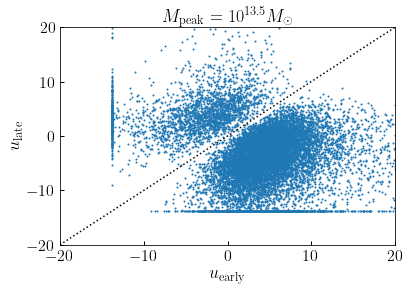

In [15]:
from diffprof.ellipticity_evolution import get_unbounded_params
get_unbounded_params_vmap = jjit(vmap(get_unbounded_params, in_axes=(0, )))
p = sample['e_lgtc'], sample['e_k'], sample['e_early'], sample['e_late']
up = get_unbounded_params_vmap(p)
u_e_early = up[:, 2]
u_e_late = up[:, 3]

fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(-20, 20)
ylim = ax.set_ylim(-20, 20)
_x = np.linspace(-100, 100, 5000)
__=ax.plot(_x, _x, ':', color='k')
__=ax.scatter(u_e_early[::5], u_e_late[::5], s=1)

xlabel = ax.set_xlabel(r'$u_{\rm early}$')
ylabel = ax.set_ylabel(r'$u_{\rm late}$')
title = ax.set_title(r'$M_{\rm peak}=10^{13.5}M_{\odot}$')


Now let's exclude those outliers and use the line $u_{\rm early}=u_{\rm late}$ to define the two sub-populations:

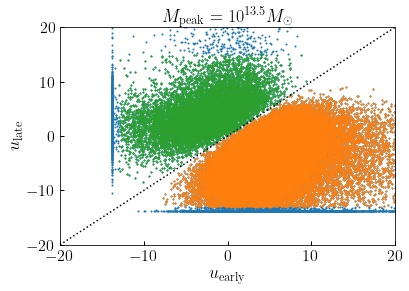

In [16]:
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(-20, 20)
ylim = ax.set_ylim(-20, 20)
_x = np.linspace(-100, 100, 5000)
__=ax.plot(_x, _x, ':', color='k')

__=ax.scatter(u_e_early, u_e_late, s=1)

rounder_msk = u_e_early > u_e_late
early_boundary_msk = u_e_early > -13
early_boundary_msk &= u_e_early < 20
late_boundary_msk = u_e_late > -13
late_boundary_msk &= u_e_late < 15

reasonable_fits_msk = early_boundary_msk & late_boundary_msk

__=ax.scatter(u_e_early[reasonable_fits_msk&rounder_msk], u_e_late[reasonable_fits_msk&rounder_msk], s=1)
__=ax.scatter(u_e_early[reasonable_fits_msk&~rounder_msk], u_e_late[reasonable_fits_msk&~rounder_msk], s=1)

xlabel = ax.set_xlabel(r'$u_{\rm early}$')
ylabel = ax.set_ylabel(r'$u_{\rm late}$')
title = ax.set_title(r'$M_{\rm peak}=10^{13.5}M_{\odot}$')


In [17]:
rounder_sample = np.array((u_e_early[reasonable_fits_msk&rounder_msk], u_e_late[reasonable_fits_msk&rounder_msk]))
flatter_sample = np.array((u_e_early[reasonable_fits_msk&~rounder_msk], u_e_late[reasonable_fits_msk&~rounder_msk]))

Next we'll separately measure the 2d mean and covariance of the rounder and flatter subpopulations, and then just visually examine the generated distribution vs the original:

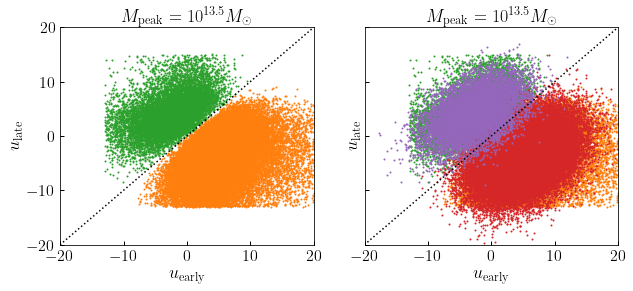

In [18]:
cov_rounder = np.cov(rounder_sample)
cov_flatter = np.cov(flatter_sample)

mu_rounder = np.mean(rounder_sample, axis=1)
mu_flatter = np.mean(flatter_sample, axis=1)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
xlim = ax0.set_xlim(-20, 20)
ylim = ax0.set_ylim(-20, 20)
_x = np.linspace(-100, 100, 5000)
for ax in ax0, ax1:
    __=ax.plot(_x, _x, ':', color='k')
    __=ax.scatter(rounder_sample[0, :], rounder_sample[1, :], s=1, color=morange)
    __=ax.scatter(flatter_sample[0, :], flatter_sample[1, :], s=1, color=mgreen)

rounder_sample_model = np.random.multivariate_normal(mu_rounder, cov_rounder, size=rounder_sample.shape[1])
flatter_sample_model = np.random.multivariate_normal(mu_flatter, cov_flatter, size=flatter_sample.shape[1])

__=ax1.scatter(rounder_sample_model[:, 0], rounder_sample_model[:, 1], s=1, color=mred)
__=ax1.scatter(flatter_sample_model[:, 0], flatter_sample_model[:, 1], s=1, color=mpurple)

for ax in ax0, ax1:
    xlabel = ax.set_xlabel(r'$u_{\rm early}$')
    ylabel = ax.set_ylabel(r'$u_{\rm late}$')
    title = ax.set_title(r'$M_{\rm peak}=10^{13.5}M_{\odot}$')


Now that we have a prototype model for the distribution of $u_{\rm early}$ and $u_{\rm late}$ that looks at least broadly reasonable, let's see how this approximation performs in terms of its ability to achieve our principal goal of capturing the mean and variance of $P({\rm e}(t)\vert M_0)$. To do this, we'll proceed as above and replace the actual values of $\beta_{\rm early}$ and $\beta_{\rm late}$ with the ones generated by our Monte Carlo realization. 

The first cell below shows how to tranform back to $\beta$-space after first generating the variables $u_{\rm early}$ and $u_{\rm late}.$ Then the next cell calculates the mean and variance of the ellipticity histories:

In [19]:
n_sample = len(sample)

mu_lgtc, std_lgtc = 0.8, 0.2
e_lgtc_model = np.random.normal(loc=mu_lgtc, scale=std_lgtc, size=n_sample)

e_k_model = np.random.uniform(0.25, 4.0, n_sample)

frac_rounder = rounder_sample_model.shape[0] / (rounder_sample_model.shape[0]+flatter_sample_model.shape[0])
n_rounder = int(frac_rounder*n_sample)
n_flatter = n_sample - n_rounder

e_u_el_rounder = np.random.multivariate_normal(mu_rounder, cov_rounder, size=n_rounder)
e_u_el_flatter = np.random.multivariate_normal(mu_flatter, cov_flatter, size=n_flatter)
e_u_el = np.vstack((e_u_el_rounder, e_u_el_flatter))
e_u_early_model = e_u_el[:, 0]
e_u_late_model = e_u_el[:, 1]

from diffprof.ellipticity_evolution import _sigmoid, _X0, _K, PARAM_BOUNDS
e_early_model = _sigmoid(e_u_early_model, _X0, _K, *PARAM_BOUNDS['e_early'])
e_late_model = _sigmoid(e_u_late_model, _X0, _K, *PARAM_BOUNDS['e_late'])

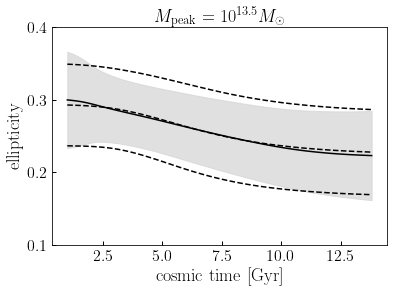

In [20]:
_args = 10**sample['e_lgtc'], sample['e_k'], sample['e_early'], sample['e_late']
e_history_sample = e_vs_t_vmap(tarr, *_args)

_args = 10**e_lgtc_model, e_k_model, e_early_model, e_late_model
e_history_model = e_vs_t_vmap(tarr, *_args)

e_h_med_true = np.mean(e_history_sample, axis=0)
e_h_std_true = np.std(e_history_sample, axis=0)

e_h_med_model = np.mean(e_history_model, axis=0)
e_h_std_model = np.std(e_history_model, axis=0)

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0.1, 0.4)
__=ax.fill_between(tarr, e_h_med_true-e_h_std_true, e_h_med_true+e_h_std_true, alpha=0.7, color='lightgray')
__=ax.plot(tarr, e_h_med_true, color='k')

__=ax.plot(tarr, e_h_med_model, '--', color='k')
__=ax.plot(tarr, e_h_med_model-e_h_std_model, '--', color='k')
__=ax.plot(tarr, e_h_med_model+e_h_std_model, '--', color='k')

xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'${\rm ellipticity}$')
title = ax.set_title(r'$M_{\rm peak}=10^{13.5}M_{\odot}$')


Not bad at all! Remember these parameters are all hand-tuned by eye, and so I think we can declare these functional forms "good enough for now" and proceed to the next step of optimizing the parameters for an individual mass bin.

### Final comment about a possible modeling limitation

One thing to be aware of is that we are going down a road of treating the distribution of $\tau_{\rm e}$ as being separable from the joint 2d distribution of $\beta_{\rm early}-\beta_{\rm late}.$ Mathematically, what I mean is that we are assuming the following:

$P(\tau_{\rm e}, \beta_{\rm early}, \beta_{\rm late}\vert M_0) = P(\tau_{\rm e}\vert M_0)\times P(\beta_{\rm early}, \beta_{\rm late}\vert M_0)$


This _might_ be fine for our purposes, and we'll definitely start out this way for the sake of simplicity, but it might also be a level of complexity that we'll need to improve upon in the future. So as a quick check of this, let's just take a look at how the distributions of $\tau_{\rm e}$ differ between the two subpopulations of $\beta$:

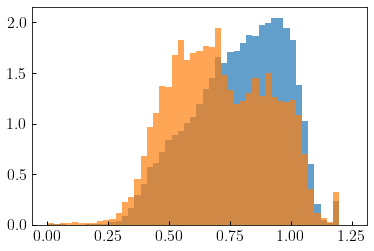

In [21]:
fig, ax = plt.subplots(1, 1)
b = np.linspace(0, 1.25)
__=ax.hist(sample['e_lgtc'][reasonable_fits_msk&rounder_msk], bins=b, density=True, alpha=0.7)
__=ax.hist(sample['e_lgtc'][reasonable_fits_msk&~rounder_msk], bins=b, density=True, alpha=0.7)

In [22]:
print(np.mean(10**sample['e_lgtc'][reasonable_fits_msk&rounder_msk]))
print(np.mean(10**sample['e_lgtc'][reasonable_fits_msk&~rounder_msk]))

6.598273430317224
5.492281016263831


## Run the fitter for this example halo mass 

Now that we have settled on a prototype for our functional forms, let's try and optimize the parameters for this specific halo mass. We'll do this using scipy.optimize.minimize. There is now a new module in the diffprof package that generates a Monte Carlo realization of the model developed in this notebook, `predict_e_history_singlemass`, so we'll use that module as a convenience.

This first cell defines the initial guess for our best-fit parameters based on the parameter dictionary stored in this module. We'll also define the target cosmic times that we'll use to optimize our model's predictions.

In [23]:
from diffprof.predict_e_history_singlemass import DEFAULT_U_PARAMS

p_default = np.array(list(DEFAULT_U_PARAMS.values()))
tarr_fit = np.linspace(2.5, 13.8, 50)

In the next cell, we'll define the target data to be the mean and variance of the ellipticity history of a sample of halos with mass $M_{\rm peak}\approx10^{13.5}M_{\odot}.$ This is what is expected by the loss function defined in the `predict_e_history_singlemass` module.

In [24]:
logmp_sample = 13.5

mmsk = np.abs(mdpl_fits['logmp'] - logmp_sample) < 0.1
sample = mdpl_fits[mmsk]

e_history_target = e_vs_t_vmap(tarr_fit, 10**sample['e_lgtc'], sample['e_k'], sample['e_early'], sample['e_late'])
e_mean_target = np.mean(e_history_target, axis=0)
e_std_target = np.std(e_history_target, axis=0)

loss_data = tarr_fit, e_mean_target, e_std_target

Now we tell `scipy.optimize.minimize` what function we want to minimize, and we additionally pass our initial guess and also the target data expected by the definition of our loss function. We also specify the optimization algorithm to use; after some experimentation, I found that `Nelder-Mead` performed best for our problem. Just remember that there a number of choices that we can use for the optimization algorithm, and different ones perform better or worse depending on the form of the problem. 

Notice that I call the optimizer two times in succession: once with the initial guess, and time using the best-fit point from the first iteration as the initial guess. This is just a trick to help ensure that we reach a good-fitting point. Sometimes it's not necessary, but I found more stable results if I did this, so it's a good trick to remember: as a sort of obvious general rule, the higher quality the initial guess, the better the fit will be in the end.

In [ ]:
from scipy.optimize import minimize
from diffprof.predict_e_history_singlemass import loss

res = minimize(loss, p_default, args=(loss_data, ), method='Nelder-Mead')
res = minimize(loss, res.x, args=(loss_data, ), method='Nelder-Mead')
p_best = res.x
print(res.message)

Now that we have a best-fitting point in parameter space, let's inspect the results. In the next cell, we'll generate a Monte Carlo realization of the parameter distribution based on our best-fitting point, and we'll also generate a prediction for the mean and variance of $P({\rm e}(t)\vert M_0),$ which is what we used to optimize the parameters. In the next cell we'll plot the results.

In [ ]:
from diffprof.predict_e_history_singlemass import mc_generate_e_history
from diffprof.predict_e_history_singlemass import mc_generate_e_params

e_history_best = mc_generate_e_history(tarr_fit, p_best)
e_h_med_best = np.mean(e_history_best, axis=0)
e_h_std_best = np.std(e_history_best, axis=0)

n_sample = len(sample)
lgtc_best, k_best, early_best, late_best = mc_generate_e_params(n_sample, *p_best)

In the bottom-right panel we'll see how accurately we were able to approximate the mean and variance of $P({\rm e}(t)\vert M_0),$ and the remaining panels compare the distribution of the true and model parameters. Remember that the actual goal we set out to achieve is the agreement between predicted and simulated $P({\rm e}(t)\vert M_0),$ and so the fact that the actual distribution of best-fitting parameters is not perfect is not such a big concern so long as they are broadly reasonable.

In [ ]:
fig, _axes = plt.subplots(2, 2, figsize=(10, 8))
fig.tight_layout(pad=3.0)
(ax0, ax1), (ax2, ax3) = _axes

lgtc_bins = np.linspace(-0.5, 1.5, 100)
__=ax0.hist(sample['e_lgtc'], bins=lgtc_bins, density=True, alpha=0.8, label=r'${\rm simulated\ halos}$')
__=ax0.hist(lgtc_best, bins=lgtc_bins, density=True, alpha=0.8, label=r'${\rm halo\ population\ model}$')
xlabel = ax0.set_xlabel(r'$\log_{10}\tau_{\rm e}$')
leg0 = ax0.legend()
ylim0 = ax0.set_ylim(0, 4.5)

k_bins = np.linspace(0.25, 4, 100)
__=ax1.hist(sample['e_k'], bins=k_bins, density=True, alpha=0.8)
__=ax1.hist(k_best, bins=k_bins, density=True, alpha=0.8)
xlabel = ax1.set_xlabel(r'$k_{\rm e}$')

xlim = ax2.set_xlim(0., 0.6)
ylim = ax2.set_ylim(0., 0.6)

__=ax2.scatter(sample['e_early'], sample['e_late'], s=1)
__=ax2.scatter(early_best, late_best, s=1)
xlabel = ax2.set_xlabel(r'$\beta_{\rm early}$')
ylabel = ax2.set_ylabel(r'$\beta_{\rm late}$')

ylim = ax3.set_ylim(0.1, 0.4)
__=ax3.fill_between(tarr_fit, e_mean_target-e_std_target, e_mean_target+e_std_target, alpha=0.7, color='lightgray')
__=ax3.plot(tarr_fit, e_mean_target, color='k', label=r'${\rm simulated\ halos}$')

__=ax3.plot(tarr_fit, e_h_med_best, '--', color=morange, label=r'${\rm halo\ population\ model}$')
__=ax3.plot(tarr_fit, e_h_med_best-e_h_std_best, ':', color=morange)
__=ax3.plot(tarr_fit, e_h_med_best+e_h_std_best, ':', color=morange)
leg = ax3.legend()

xlabel = ax3.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax3.set_ylabel(r'${\rm ellipticity}$')
title = ax0.set_title(r'$M_{\rm peak}=10^{13.5}M_{\odot}$')
title = ax1.set_title(r'$M_{\rm peak}=10^{13.5}M_{\odot}$')

fig.savefig('example_ellipticity_fit_logmp_13.5.png', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)